# Matemática Discreta - A2
### Otimização Rede de Transporte
###### Rafael Barsotti
###### Rafael Figueredo

###### Problema: Implementar um algoritmo capaz de otimizar as quantidades que devem ser enviadas de um conjunto de nós de "oferta" para um conjunto de nós de "demanda" minimizando o custo total de transporte das arestas entre (i,j).

###### Método: Para resolver esse problema utilizaremos programação linear (simplex) vs guloso.

In [3]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import linprog
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import vincenty

<p align="center">
  <img src="http://docsdrive.com/images/ansinet/jas/2012/fig1-2k12-2430-2435.gif"/></p>

<h3><center> Exemplo: </center></h3>

<h3><center> Matriz de Distância</center></h3>

|   |  Rio | SP  |  
|---|---|---|---|---|
|  Curitiba |  842,5 | 416,6  | 
|  Salvador |  1.631,4 | 2.027,2  |   
|  Vitória |  523,2 | 953,8 |   

<h3><center> Matriz de Transporte</center></h3>

|   |  SP | Rio  |  Oferta |
|---|---|---|---|---|---|
|  Curitiba |  80  | 215  | 1000 | 
|  Salvador |  100  | 108  | 1300 |  
|  Vitória  |  102  | 68 | 1200 |
|  Demanda  |  2300  | 1400 | |

$Minimize$  $z = 80x_{11} + 215x_{12} + 100x_{21} + 108x_{22} + 102x_{31} + 68x_{32}$

$s.t$

$x_{11} + x_{12} = 1000$

$x_{21} + x_{22} = 1300$ 

$x_{31} + x_{32} = 1200$

$x_{11} + x_{21} + x_{31} = 2300$

$x_{12} + x_{22} + x_{32} = 1400$

$x_{i,j} \geq 0$ 

In [18]:
# Utilizando Solver de Programação Linear 
# Ex.1 
# Demanda == Oferta

def lin_solver_1():
    c = np.array([80, 215, 100, 108, 102 , 68])

    A = np.array([[1,1,0,0,0,0],
                  [0,0,1,1,0,0],
                  [0,0,0,0,1,1],
                  [1,0,1,0,1,0],
                  [0,1,0,1,0,1]]) 
     
    b = np.array([1000, 1500, 1200, 2300, 1400])

    res = linprog(c,A_eq=A, b_eq = b,bounds=(0, None))
    print("O vetor de quantidades ótimas é {}".format(res))

lin_solver_1()

O vetor de quantidades ótimas é      fun: 313200.0
 message: 'Optimization terminated successfully.'
     nit: 7
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1000.,    0., 1300.,  200.,    0., 1200.])


<h3><center> Demanda &ge; Oferta </center></h3>

<h3><center> Matriz de Transporte</center></h3>

|   |  SP | Rio  | Oferta |
|---|---|---|---|---|---|
|  Curitiba |  80  | 215  | 1000 |
|  Salvador |  100  | 108  | 1300  |
|  Vitória  |  102  | 68 | 1200 |
|  Dummy  |   0 | 0 | 200 | 
|  Demanda  |   2300 | 1400 |  |


$Minimize$  $z = 80x_{1,1} + 215x_{1,2} + 100x_{2,1} + 108x_{2,2} + 102x_{3,1} + 68x_{3,2} + 0x_{4,1} + 0x_{4,2}$

$s.t$

$x_{1,1} + x_{1,2} = 1000$

$x_{2,1} + x_{2,2} = 1300$ 

$x_{3,1} + x_{3,2} = 1200$

$x_{4,1} + x_{4,2} = 200$

$x_{1,1} + x_{2,1} + x_{3,1} + x_{4,1} = 2300$

$x_{1,2} + x_{2,2} + x_{3,2} + x_{4,2} = 1400$


$x_{i,j} \geq 0$ 

In [22]:
# Utilizando Solver de Programação Linear 
# Ex.1 
# Demanda > Oferta

def lin_solver_2():
    c = np.array([80, 215, 100, 108, 102 , 68, 0, 0])

    A = np.array([[1,1,0,0,0,0,0,0],
                  [0,0,1,1,0,0,0,0],
                  [0,0,0,0,1,1,0,0],
                  [0,0,0,0,0,0,1,1],
                  [1,0,1,0,1,0,1,0],
                  [0,1,0,1,0,1,0,1]]) 
     
    b = np.array([1000, 1300, 1200, 200, 2300, 1400])

    res = linprog(c,A_eq=A, b_eq = b,bounds=(0, None))
    print("O vetor de quantidades ótimas é {}".format(res))
    
lin_solver_2()

O vetor de quantidades ótimas é      fun: 291600.0
 message: 'Optimization terminated successfully.'
     nit: 10
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1000.,    0., 1300.,    0.,    0., 1200.,    0.,  200.])


<h3><center> Demanda &le; Oferta </center></h3>

<h3><center> Matriz de Transporte</center></h3>

|   |  SP | Rio  | Dummy | Oferta |
|---|---|---|---|---|---| ---|
|  Curitiba |  80  | 215  | 0 | 1000 |
|  Salvador |  100  | 108 | 0 | 1500|
|  Vitória  |  102  | 68 | 0 |  1200 |
|  Demanda  |  1900  | 1400 | 400 | |

$Minimize$  $z = 80x_{1,1} + 215x_{1,2} + 0x_{1,3} + 100x_{2,1} + 108x_{2,2} + 0x_{2,3} + 102x_{3,1} + 68x_{3,2} + 0x_{3,3} $

$s.t$

$x_{1,1} + x_{1,2} = 1000$

$x_{2,1} + x_{2,2} = 1500$ 

$x_{3,1} + x_{3,2} = 1200$

$x_{1,1} + x_{2,1} + x_{3,1} = 1900$

$x_{1,2} + x_{2,2} + x_{3,2} = 1400$

$x_{1,3} + x_{2,3} + x_{3,3} = 400$


$x_{i,j} \geq 0$ 

In [16]:
# Utilizando Solver de Programação Linear 
# Ex.1 
# Demanda < Oferta

def lin_solver_3():
    c = np.array([80, 215, 0, 100, 108, 0, 102 , 68, 0])

    A = np.array([[1,1,1,0,0,0,0,0,0],
                  [0,0,0,1,1,1,0,0,0],
                  [0,0,0,0,0,0,1,1,1],
                  [1,0,0,1,0,0,1,0,0],
                  [0,1,0,0,1,0,0,1,0],
                  [0,0,1,0,0,1,0,0,1]]) 
     
    b = np.array([1000, 1500, 1200, 1900, 1400, 400])

    res = linprog(c,A_eq=A, b_eq = b,bounds=(0, None))
    print("O vetor de quantidades ótimas é {}".format(res))

lin_solver_3()

O vetor de quantidades ótimas é      fun: 273200.0
 message: 'Optimization terminated successfully.'
     nit: 9
   slack: array([], dtype=float64)
  status: 0
 success: True
       x: array([1000.,    0.,    0.,  900.,  200.,  400.,    0., 1200.,    0.])


<h3><center> Solver Geral </center></h3>

In [129]:
# Algoritmo que puxa dados de 3 csv`s e monta um grafo bipartido utilizando um solver simplex para otimizar as
# quantidades que devem ser enviadas nos arcos (i,j)

# Lista de Adjacência
def get_local_edge_list():
    location = r"/home/nbuser/library/Edge_List_UTF8.csv"
    df = pd.read_csv(location,header=0, quotechar='"',sep=';',encoding='utf8')
    df = df.as_matrix()
    edge_list = []
    for i in range(len(df) - 1):
        edge = (df[i,0],df[i,1])
        edge_list.append(edge)
    return edge_list


# Tabela de Nó,Oferta
def get_local_supply_nodes():
    location = r"/home/nbuser/library/Supply_Nodes_UTF8.csv"
    df = pd.read_csv(location,header=0, quotechar='"',sep=';',encoding='utf8')
    df = df.as_matrix()
    return df


# Tabela de Nó,Demanda
def get_local_demand_nodes():
    location = r"/home/nbuser/library/Demand_Nodes_UTF8.csv"
    df = pd.read_csv(location,header=0, quotechar='"',sep=';',encoding='utf8')
    df = df.as_matrix()
    return df


# Plota Grafo
def plot_local_edge_list():
    Supply_Nodes = get_local_supply_nodes()
    Supply_Nodes = list(Supply_Nodes[:,1])
    Demand_Nodes = get_local_demand_nodes()
    Demand_Nodes = list(Demand_Nodes[:,1])
    Edge_List = get_local_edge_list()
    
    B = nx.Graph()
    B.add_nodes_from(Supply_Nodes, bipartite=0) 
    B.add_nodes_from(Demand_Nodes, bipartite=1)
    B.add_edges_from(Edge_List)
    l, r = nx.bipartite.sets(B)
    pos = {}
    pos.update((node, (1, index)) for index, node in enumerate(l))
    pos.update((node, (2, index)) for index, node in enumerate(r))
    nx.draw(B, pos=pos,with_labels=True)
    return plt.show()


# Distância Duas Cidades
def distance(start, end):
    geolocator = Nominatim()
    one = geolocator.geocode(start)
    two = geolocator.geocode(end)
    return round(vincenty((one.latitude, one.longitude), (two.latitude, two.longitude)).miles * 1.6, 1)


# Printa Distância entre Cidades
def distance_edge_list():
    edge_list = get_local_edge_list()
    l = []
    for i in edge_list:
        start = i[0]
        end = i[1]
        d = distance(start,end)
        print("A distância entre {} e {} é {} km.".format(start,end,d))
        
# General Solver
def general_solver(df):
    df = df.sort_values(['SUPPLY','DEMAND'])
    SUPPLY_index = df.columns.get_loc('SUPPLY')
    supply.index = df.columns.get_loc('AMOUNT')
    supply = list(pd.unique(df.EdgeList))
    supply = [x for x in supply if str(x) != 'nan']
    hist_supply_columns = []
    for i in supply:
        column_name = 'Demand_'+str(i)
        df[column_name] = 0
        supply_index = df.columns.get_loc(column_name)
        supply_columns.append(supply_nodes)
    supply_indexes = list(zip(supply,supply_columns))
    columns = list(df.columns)
    df = df.as_matrix()
    for i in range(len(supply_indexes)):
        demand_atual = supply_indexes[i][0]
        coluna_atual = supply_indexes[i][1]
        for j in range(1,len(df)):
            if df[j-1,categoria_demand_index] == demand_atual or (df[j,SUPPLY_index] == df[j-1,SUPPLY_index] and 
                                                                  df[j-1,coluna_atual] == 1):
                df[j,coluna_atual] = 1
    df = pd.DataFrame(df, columns = columns)
    return df

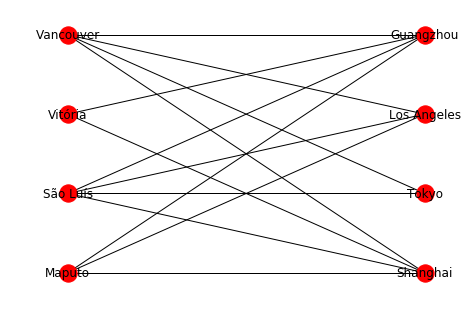

A distância entre Vitória e Shanghai é 9967.8 km.
A distância entre Vitória e Guangzhou é 10143.2 km.
A distância entre São Luís e Shanghai é 16403.6 km.
A distância entre São Luís e Guangzhou é 16598.8 km.
A distância entre São Luís e Los Angeles é 8648.7 km.
A distância entre São Luís e Tokyo é 16327.3 km.
A distância entre Vancouver e Shanghai é 8993.8 km.
A distância entre Vancouver e Guangzhou é 10187.8 km.
A distância entre Vancouver e Los Angeles é 1725.9 km.
A distância entre Vancouver e Tokyo é 7625.4 km.
A distância entre Maputo e Shanghai é 11284.2 km.
A distância entre Maputo e Guangzhou é 10170.3 km.
A distância entre Maputo e Los Angeles é 17008.0 km.


In [130]:
plot_local_edge_list()
distance_edge_list()

In [3]:
general_solver(df)

O vetor de quantidades ótimas é [2271.34, 1423.65, 4494.78, 1973.32, 2644.1, 2140.12, 1803.4, 4700.57, 2686.77, 4489.23, 766.9, 1756.63, 4659.82]


<h3><center> Algoritmo Guloso </center></h3>

In [17]:
# Segue um algoritimo guloso simples que buscar abastecer o no de demanda pelos nos de oferta mais proximos
# ate que sua demanda seja satisfeita
# (As unicas funcoes nao definidas aqui e utilizadas sao as de leitura dos arquivos csv definidas anteriormente)

# Sort Shipping List Based on Proximity
def getNearestNeighbor(df):
    nearest = [-1, float("inf")]
    for index in range(len(nodes)):
        if i == index or nodes[index][3] == True:
            pass
        else:
            distance = distance(nodes[index], nodes[index])
            if distance < nearest[1]:
                nearest = [index, distance]
    nodes[nearest[0]][3] = True
    return nearest

#Calculate `best` Shipping on a given set of vertexes
def nearestNeighbor(nodes):
    demand = []
    supply = [[],0]
    first = getNearestNeighbor(0)
    demand.append(first)
    next = first
    for index in range(1,len(nodes)):
        cur = getNearestNeighbor(next[0])
        data.append(cur)
        next = cur

    for element in data:
        supply[1] += element[1]
        supply[0].append(element[0])
    supply.append(distance(nodes[supply[0][-1]],nodes[supply[0][0]]))
    print("O vetor de quantidades ótimas é {}".format(supply))

In [16]:
nearestNeighbor(nodes)

O vetor de quantidades ótimas é [3171.37, 1023, 5594.78, 2106.15, 1435.19, 890.72, 1504.4, 5043.9, 1546.27, 7632.33, 766.17, 2341.55, 2754.28]


<h3><center> Relatório </center></h3>

<p>Nesse segundo trabalho de matemática escolhemos fazer sobre otimização em redes com o objetivo de montar um "produto" bem geral capaz de utilizarmos em nossos estágios ou outras oportunidades. Apesar de termos lido sobre metodos mais gerais escolhemos dividir o trabalho em um algoritmo de programação linear e um algoritmo guloso. A vantagem principal sendo se aprofundar mais em programação linear que pode ser extensamente usado em diversas aplicações industriais (como no exemplo acima) e financeiras como alocação de ativos de um portfólio. A maior dificuldade foi justamente modelar o problema de forma linear mas apos alguns exemplos entendemos a ideia e conseguimos montar balanceando os fluxos nos nós. Utilizamos como base o livro de pesquisa operacional do Taha.</p>

In [ ]:
import keras

Using TensorFlow backend.


In [2]:
import gym

In [ ]:
!pip install h2o

    100% |████████████████████████████████| 130.6MB 2.7kB/s ta 0:00:01 0% |                                | 204kB 1.9MB/s eta 0:01:08    0% |                                | 358kB 2.5MB/s eta 0:00:52    0% |▏                               | 491kB 1.3MB/s eta 0:01:43    0% |▏                               | 624kB 2.0MB/s eta 0:01:07    1% |▍                               | 1.7MB 1.2MB/s eta 0:01:50    3% |█▏                              | 4.9MB 346kB/s eta 0:06:03    7% |██▌                             | 10.4MB 335kB/s eta 0:05:58    9% |███                             | 12.1MB 623kB/s eta 0:03:11    10% |███▎                            | 13.3MB 650kB/s eta 0:03:01    10% |███▌                            | 14.3MB 555kB/s eta 0:03:30    11% |███▋                            | 14.7MB 1.2MB/s eta 0:01:39    12% |████                            | 16.1MB 1.3MB/s eta 0:01:30    12% |████                            | 16.7MB 1.9MB/s eta 0:01:00    12% |████▏                           | 17.0MB 

In [ ]:
impo